### DS-207: Kaggle Competition | EEG Seizure Prediction Competition

>Epilepsy afflicts nearly 1% of the world's population, and is characterized by the occurrence of spontaneous seizures. For many patients, anticonvulsant medications can be given at sufficiently high doses to prevent seizures, but patients frequently suffer side effects. For 20-40% of patients with epilepsy, medications are not effective. Even after surgical removal of epilepsy, many patients continue to experience spontaneous seizures. Despite the fact that seizures occur infrequently, patients with epilepsy experience persistent anxiety due to the possibility of a seizure occurring.

>Seizure forecasting systems have the potential to help patients with epilepsy lead more normal lives. In order for electrical brain activity (EEG) based seizure forecasting systems to work effectively, computational algorithms must reliably identify periods of increased probability of seizure occurrence. If these seizure-permissive brain states can be identified, devices designed to warn patients of impeding seizures would be possible. Patients could avoid potentially dangerous activities like driving or swimming, and medications could be administered only when needed to prevent impending seizures, reducing overall side effects.\n",

From the competition [homepage](https://www.kaggle.com/c/melbourne-university-seizure-prediction).

### Goal for this Notebook:
* Use L1-regularized LR to select features
* Parameter tuning using Bayesian optimization
* Learn how to use xgboost
* Use stacking to ensemble models

#### Required Libraries:
* [NumPy](http://www.numpy.org/)
* [IPython](http://ipython.org/)
* [Pandas](http://pandas.pydata.org/)
* [SciKit-Learn](http://scikit-learn.org/stable/)
* [Matplotlib](http://matplotlib.org/)
* [Xgboost](http://xgboost.readthedocs.io/en/latest/build.html)
* [bayes_opt]()

In [18]:
import pandas as pd
class Datawarehouse():
    def __init__(self):
        # Initialize Datawarehouse.
        self.TRAIN_FILE = '../input/train.csv'
        self.TEST_FILE = '../input/test.csv'
        self.GROUP_FILE = '../input/group.csv'
        self.DATA_ID = 'File'
        self.DATA_OUT_NAME = 'Class'
    
    def read_data(self):
        # Read in training and testing data for further processing
        self.train_in = pd.read_csv(self.TRAIN_FILE)
        self.test_in = pd.read_csv(self.TEST_FILE)
        self.group = pd.read_csv(self.GROUP_FILE)
        
        # get response variable and id
        self.col_name = self.train_in.columns
        self.train_out = self.train_in[self.DATA_OUT_NAME]
        self.train_id = self.train_in[self.DATA_ID]

        # remove unnecessary information
        del self.train_in[self.DATA_ID]
        del self.train_in[self.DATA_OUT_NAME]

        # get test id
        self.test_id = self.test_in[self.DATA_ID]
        
        # remove unnecessary information from test as well
        del self.test_in[self.DATA_ID]

        # get group
        del self.group[self.DATA_ID]

        self.train_in = self.train_in.as_matrix()
        self.train_out = self.train_out.as_matrix()
        self.test_in = self.test_in.as_matrix()
        self.group = self.group.as_matrix()
    
    def select_features(self, vec):
        """ Select features given a boolean vector

        Arguments:
            vec (ndarray): a boolean vector to indicate what features to keep
        """
        self.train_in = self.train_in[:,vec]
        self.test_in = self.test_in[:,vec]
    
    def gen_submission(self, ypred, filename):
        """ Generate submission files based on given prediction results

        Arguments:
            ypred (ndarray): a numeric vector storing probability
        """
        dataset = list(zip(self.test_id, ypred))

        # transform list to data frame
        df_pred = pd.DataFrame(dataset, columns = [self.DATA_ID, self.DATA_OUT_NAME], index=None)
        df_pred.to_csv(filename, index=False)

In [13]:
train = pd.read_csv('../input/train.csv')

In [14]:
train

,File,SigMean_C1,SigMean_C2,SigMean_C3,SigMean_C4,SigMean_C5,SigMean_C6,SigMean_C7,SigMean_C8,SigMean_C9,...,WaveletR8_C8,WaveletR8_C9,WaveletR8_C10,WaveletR8_C11,WaveletR8_C12,WaveletR8_C13,WaveletR8_C14,WaveletR8_C15,WaveletR8_C16,Class
0,1_7_0.mat,-0.288530,0.324564,-0.002718,0.050880,0.146694,-0.736724,-0.265787,-0.800872,-0.454978,...,0.394613,1.075273,-0.866328,-0.078471,-0.640318,-0.210430,-0.824698,0.523578,-0.091089,0
1,1_8_0.mat,-0.048981,-0.093086,-0.123211,0.576776,-0.059393,-0.626494,-0.288666,-1.123369,-1.058181,...,3.960875,3.582588,-0.785167,1.371965,-0.095059,-0.210288,-0.517351,3.076091,1.487048,0
2,1_9_0.mat,-0.168991,0.137907,0.106642,-0.239069,-0.695586,-1.335152,-0.421489,-1.152721,-0.869702,...,4.068216,3.496801,-0.770978,1.984995,0.122791,-0.209740,0.028066,3.771308,2.205124,0
3,1_10_0.mat,-0.199351,-0.573721,-0.527654,0.060454,-0.342314,-1.070089,-0.899636,-1.362659,-1.266849,...,3.214353,3.345645,-0.776387,1.197794,-0.173821,-0.210032,-0.429824,2.981368,1.241364,0
4,1_11_0.mat,0.017845,0.010380,-0.022627,0.094499,-0.046953,-0.936635,-0.546479,-0.991634,-0.663843,...,4.601992,3.607907,-0.779511,1.731818,-0.051429,-0.210167,-0.369933,4.052383,2.052193,0
5,1_12_0.mat,0.014489,0.130260,0.082293,0.071109,-0.102388,-1.003618,-0.422200,-1.093781,-0.668133,...,5.240694,4.073852,-0.767021,1.792692,-0.015426,-0.210365,-0.517251,3.994455,2.011985,0
6,1_13_0.mat,-0.655157,0.457431,0.140928,0.072871,-0.366381,-1.075830,-0.403581,-1.694735,-0.391248,...,5.449587,2.865873,-0.748247,1.190386,-0.160518,-0.209625,0.293477,2.675517,2.167857,0
7,1_14_0.mat,0.576938,-0.021378,1.319599,-0.323885,-1.541729,-0.644021,-0.693023,-3.264855,1.226745,...,5.731851,4.206076,-0.651534,2.545810,0.387698,-0.209287,0.332244,4.419004,2.935790,0
8,1_15_0.mat,0.508465,-0.365782,-0.653625,-0.290081,0.490278,0.147102,-0.857894,-0.593983,-0.182086,...,-0.408528,0.264590,-0.894032,-0.706963,-0.830039,-0.210508,-0.961791,-0.352436,-0.911083,0
9,1_16_0.mat,-0.017030,0.316921,0.026681,0.078928,-0.083321,-0.622562,-0.509687,-0.653605,-0.235385,...,-1.645358,-0.752254,-0.931867,-1.095465,-0.994557,-0.210540,-1.031693,-1.033472,-1.365559,0


In [16]:
groups = pd.read_csv('../input/group.csv')

In [17]:
groups

,File,Group
0,1_7_0.mat,1
1,1_8_0.mat,1
2,1_9_0.mat,1
3,1_10_0.mat,1
4,1_11_0.mat,1
5,1_12_0.mat,1
6,1_13_0.mat,2
7,1_14_0.mat,2
8,1_15_0.mat,2
9,1_16_0.mat,2


In [19]:
#!/usr/bin/env python -W ignore::DeprecationWarning
from sklearn.model_selection import GroupShuffleSplit, KFold, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc

import numpy as np
import xgboost as xgb

class Model():
    def __init__(self, mdl_type, param):
        """ Initialize classififer based on classifier type and related parameters

        Arguments:
            mdl_type (string): a string to tell which classifier to use
            param: a dictionary to store related parameters
            
        """
        self.param = param
        self.mdl_type = mdl_type
        if (mdl_type == 'xgb'):
            self.clf = xgb.XGBClassifier(**param)
        elif (mdl_type == 'lr'):
            self.clf = LogisticRegression(**param)
        elif (mdl_type == 'extra'):
            self.clf = ExtraTreesClassifier(**param)
        elif (mdl_type == 'rf'):
            self.clf = RandomForestClassifier(**param)

    # training the model based on input data
    def train(self, data_in, data_out):
        """ Train classifier based on input data and corresponding labels

        Arguments:
            data_in (ndarray): feature matrix for training classifier
            data_out (ndarray): binary output labels for each row of feature matrix
        """
        if(self.mdl_type=='xgb'):
            self.clf.fit(data_in, data_out, eval_metric='auc')
        else:
            self.clf.fit(data_in, data_out)

    # split into k fold and find auc for each fold (for testing purpose)
    def score_kfold(self, data_in, data_out, ns):
        """ Get the score of k-fold cross validation

        Arguments:
            data_in (ndarray): feature matrix for training classifier
            data_out (ndarray): binary output labels for each row of feature matrix
            num_fold: number of folds for cross validation 
        
        Returns:
            val_mean: mean of k-fold cross validation score
            val_std: standard deviation of k-fold cross validation score
        """
        # cut into k-folds
        kf = KFold(n_splits=ns, shuffle=True)
        self.score = []
        for train_idx, test_idx in kf.split(data_in, y=data_out):
            # divide into trainig and test set
            train_in = data_in[train_idx, :]
            train_out = data_out[train_idx]
            test_in = data_in[test_idx, :]
            test_out = data_out[test_idx]

            # fit model
            self.train(train_in, train_out)
            test_pred = self.predict(test_in)

            # get score
            self.score.append(self.get_score(test_out, test_pred))

        # return score mean and std
        print(self.score)
        return np.mean(self.score), np.std(self.score)

    def score_group_kfold(self, data_in, data_out, groups, ns):
        """ Get the score of group cross validation

        Arguments:
            data_in (ndarray): feature matrix for training classifier
            data_out (ndarray): binary output labels for each row of feature matrix
            groups (ndarray): group information of input data
            ns: number of splits for cross validation
        
        Returns:
            val_mean: mean of k-fold cross validation score
            val_std: standard deviation of k-fold cross validation score
        """
        gkf = GroupShuffleSplit(n_splits=ns, random_state=0)
        self.score = []
        for train_idx, test_idx in gkf.split(data_in, y=data_out, groups=groups):
            # divide into trainig and test set
            train_in = data_in[train_idx, :]
            train_out = data_out[train_idx]
            test_in = data_in[test_idx, :]
            test_out = data_out[test_idx]

            # fit model
            self.train(train_in, train_out)
            test_pred = self.predict(test_in)

            # get score
            self.score.append(self.get_score(test_out, test_pred))

        # return score mean and std
        return np.mean(self.score), np.std(self.score)

    # prediction with probability outcome
    def predict(self, data_in):
        data_out = self.clf.predict_proba(data_in)[:, 1]
        return data_out

    # get the ROC curve
    def get_score(self, test_out, test_pred):
        fpr, tpr, _ = roc_curve(test_out, test_pred)
        return auc(fpr, tpr)

In [20]:
# use group to improve cross validation
MyData = Datawarehouse()
MyData.read_data()

# setup model parameters
param = {'C':1,'penalty':'l1','max_iter':400,'n_jobs':8}
MyModelLR = Model('lr', param)

# perform cross validation
val_mean, val_std = MyModelLR.score_group_kfold(MyData.train_in, MyData.train_out, MyData.group, 6)
print(val_mean, val_std)

0.790837948072 0.0463663931922


In [21]:
# test random forest
param = {'n_estimators': 800,'criterion':'entropy','max_features':'sqrt','max_depth':10, \
        'min_samples_split':8, 'random_state':4242, 'n_jobs':8}
MyModelRF = Model('rf', param)

val_mean, val_std = MyModelRF.score_group_kfold(MyData.train_in, MyData.train_out, MyData.group, 6)
print(val_mean, val_std)

MyModelRF.train(MyData.train_in, MyData.train_out)
ypred = MyModelRF.predict(MyData.test_in)
MyData.gen_submission(ypred, 'submission_rf_all_features.csv') 

0.823487085659 0.0345062174434


In [22]:
# Use l1-regularization to select features
MyModelLR.train(MyData.train_in, MyData.train_out)

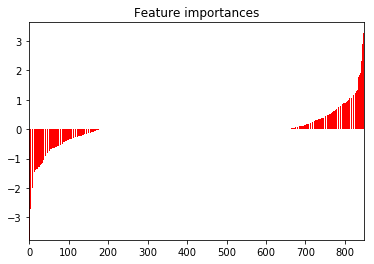

In [23]:
import matplotlib.pyplot as plt
# plot the feature importance
importances = MyModelLR.clf.coef_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(MyData.train_in.shape[1]), importances[0,indices[0]], color="r",  align="center")
plt.xlim([-1, MyData.train_in.shape[1]])
plt.show()

In [24]:
importances[0][indices[0]]

array([ -3.76305591e+00,  -3.61695525e+00,  -3.24342717e+00,
        -2.70861281e+00,  -2.22561631e+00,  -2.21808631e+00,
        -2.13047449e+00,  -2.02752110e+00,  -1.99775898e+00,
        -1.85427720e+00,  -1.65121206e+00,  -1.61221594e+00,
        -1.56681804e+00,  -1.44923689e+00,  -1.42343606e+00,
        -1.41720932e+00,  -1.40187012e+00,  -1.39896926e+00,
        -1.35978388e+00,  -1.35455225e+00,  -1.34988138e+00,
        -1.34230062e+00,  -1.33034461e+00,  -1.30337225e+00,
        -1.30026131e+00,  -1.28888709e+00,  -1.28421327e+00,
        -1.27626922e+00,  -1.20916990e+00,  -1.19312375e+00,
        -1.18055645e+00,  -1.17455154e+00,  -1.16750410e+00,
        -1.15281065e+00,  -1.11246233e+00,  -1.08561836e+00,
        -1.04209685e+00,  -1.02095062e+00,  -9.90626683e-01,
        -9.56921236e-01,  -9.34505500e-01,  -9.17005374e-01,
        -8.98487952e-01,  -8.96282141e-01,  -8.68388104e-01,
        -8.04282635e-01,  -8.02609929e-01,  -7.95469397e-01,
        -7.93094178e-01,

In [25]:
MyData.col_name[indices][0,-50:]

Index(['TimeCorr_C6_C3', 'FreqCorr_C15_C15', 'TimeCorr_C14_C10',
       'DyadicL12_C9', 'WaveletR5_C10', 'SigVar_C1', 'FreqCorr_C12_C6',
       'TimeCorr_C8_C5', 'DyadicL8_C4', 'WaveletR8_C7', 'DyadicL5_C16',
       'WaveletR2_C1', 'WaveletR7_C5', 'DyadicL10_C3', 'WaveletR1_C14',
       'TimeCorr_C12_C8', 'DyadicL7_C13', 'spectralEdgeFreq_C15',
       'WaveletR3_C12', 'deltaPower_C5', 'FreqCorr_C10_C4', 'WaveletR5_C16',
       'WaveletR7_C7', 'WaveletR2_C8', 'DyadicL10_C10', 'highGammaPower_C16',
       'Hurst_C10', 'TimeCorr_C15_C7', 'DyadicL4_C8', 'DyadicL7_C11',
       'DyadicL3_C16', 'WaveletR4_C16', 'FreqCorr_C10_C2', 'TimeCorr_C6_C4',
       'TimeEig_Rank1', 'TimeCorr_C12_C2', 'DyadicL5_C2', 'FreqCorr_C14_C6',
       'FreqCorr_C16_C8', 'TimeEig_Rank4', 'DyadicL2_C6', 'TimeCorr_C15_C13',
       'DyadicL7_C1', 'DyadicL9_C4', 'DyadicL2_C2', 'DyadicL1_C12',
       'DyadicL11_C13', 'spectralEntropy_C4', 'DyadicL1_C11',
       'lowGammaPower_C4'],
      dtype='object')

In [26]:
# Eliminate un-used features
KeepVec = (importances!=0)
MyData.select_features(KeepVec[0])

In [27]:
MyData.train_in.shape

(4972, 372)

In [28]:
# retrain random forest classifier with reduced features
param = {'n_estimators': 800,'criterion':'entropy','max_features':'sqrt','max_depth':10,\
        'min_samples_split':8, 'random_state':4242, 'n_jobs':8}
MyModelRF = Model('rf', param)
val_mean, val_std = MyModelRF.score_group_kfold(MyData.train_in, MyData.train_out, MyData.group, 6)
print(val_mean, val_std)

# Train classifier using all the data
MyModelRF.train(MyData.train_in, MyData.train_out)
ypred = MyModelRF.predict(MyData.test_in)
MyData.gen_submission(ypred, 'submission_rf_selected_features.csv') 

0.822743800815 0.0329929555428


### Parameter tuning
* Use logistic regression as example
* Play with Bayesian optimization

In [29]:
from bayes_opt import BayesianOptimization
MyData = Datawarehouse()
MyData.read_data()

In [31]:
def score_lr(C, max_iter):
    """ return score of an individual experiment
    """
    param = {'penalty':'l1','n_jobs':8}
    param['C'] = C
    param['max_iter'] = int(max_iter)
    MyModel = Model('lr', param)
    val_mean, val_std = MyModel.score_group_kfold(MyData.train_in, MyData.train_out, MyData.group, 6)
    return val_mean

In [ ]:
#!/usr/bin/env python -W ignore::DeprecationWarning
''' A quick example: use bayesian optimization to tune the parameters '''
opt = BayesianOptimization(score_lr, {'C':(0.25,5), 'max_iter':(50,500)})
opt.maximize(n_iter=1)
print(opt.res['max'])

### A Simple Data Set

In [32]:
# A simple example
import numpy as np
import matplotlib.pyplot as plt
X = np.array([ (1, 1.2), (0.8, 2), (2, 2.7), (2.4, 2.9), (3, 2.5), (1.4, 0.6),\
                     (1.6, 2.1), (2.5, 2.1), (3.5, 1.2), (3.6,2.8)])
y = np.array([-1,-1,-1,-1,-1,1,1,1,1,1])

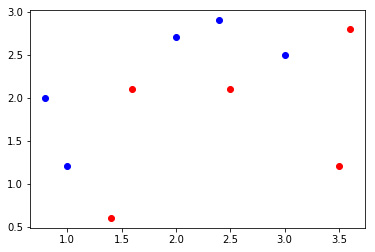

In [33]:
plt.plot(X[y==(-1),0], X[y==(-1),1], 'bo')
plt.plot(X[y==1,0], X[y==1,1], 'ro')
plt.show()

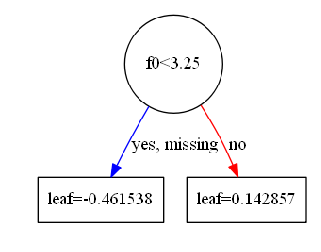

In [37]:
import xgboost as xgb

# need graphviz (conda install graphviz)
dtrain = xgb.DMatrix(X, label=y)
param = {'max_depth':1, 'learning_rate':1, 'reg_lambda':5}

# train a gradient boosting tree
bst = xgb.train(param, dtrain, num_boost_round=3)
xgb.plot_tree(bst,num_trees=0)
plt.show()

### Play with our train/test data

In [38]:
# Fit xgboost classifier
MyData = Datawarehouse()
MyData.read_data()

param = {'silent': 1, 'seed':4242, 'objective':'binary:logistic', 'max_depth':6,\
        'learning_rate':0.05, 'nthread':8, 'reg_lambda':1, 'subsample': 0.7, \
        'colsample_bytree':0.5, 'colsample_bylevel':1, 'n_estimators':800, 'reg_alpha':0}

MyModel = Model('xgb', param)
val_mean, val_std = MyModel.score_group_kfold(MyData.train_in, MyData.train_out, MyData.group, 6)
print(val_mean, val_std)

0.847276001289 0.0406276456041


In [39]:
MyModel.train(MyData.train_in, MyData.train_out)
ypred = MyModel.predict(MyData.test_in)
MyData.gen_submission(ypred, 'submission_xgb_all_features.csv') 

### Stacking

In [42]:
from sklearn.model_selection import GroupShuffleSplit, KFold, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc

import numpy as np
import xgboost as xgb

class Model():
    def __init__(self, mdl_type, param):
        """ Initialize classififer based on classifier type and related parameters

        Arguments:
            mdl_type (string): a string to tell which classifier to use
            param: a dictionary to store related parameters
            
        """
        self.param = param
        self.mdl_type = mdl_type
        if (mdl_type == 'xgb'):
            self.clf = xgb.XGBClassifier(**param)
        elif (mdl_type == 'lr'):
            self.clf = LogisticRegression(**param)
        elif (mdl_type == 'extra'):
            self.clf = ExtraTreesClassifier(**param)
        elif (mdl_type == 'rf'):
            self.clf = RandomForestClassifier(**param)

    # training the model based on input data
    def train(self, data_in, data_out):
        """ Train classifier based on input data and corresponding labels

        Arguments:
            data_in (ndarray): feature matrix for training classifier
            data_out (ndarray): binary output labels for each row of feature matrix
        """
        if(self.mdl_type=='xgb'):
            self.clf.fit(data_in, data_out, eval_metric='auc')
        else:
            self.clf.fit(data_in, data_out)

    # split into k fold and find auc for each fold (for testing purpose)
    def score_kfold(self, data_in, data_out, ns):
        """ Get the score of k-fold cross validation

        Arguments:
            data_in (ndarray): feature matrix for training classifier
            data_out (ndarray): binary output labels for each row of feature matrix
            num_fold: number of folds for cross validation 
        
        Returns:
            val_mean: mean of k-fold cross validation score
            val_std: standard deviation of k-fold cross validation score
        """
        # cut into k-folds
        kf = KFold(n_splits=ns, shuffle=True)
        self.score = []
        for train_idx, test_idx in kf.split(data_in, y=data_out):
            # divide into trainig and test set
            train_in = data_in[train_idx, :]
            train_out = data_out[train_idx]
            test_in = data_in[test_idx, :]
            test_out = data_out[test_idx]

            # fit model
            self.train(train_in, train_out)
            test_pred = self.predict(test_in)

            # get score
            self.score.append(self.get_score(test_out, test_pred))

        # return score mean and std
        print(self.score)
        return np.mean(self.score), np.std(self.score)

    def score_group_kfold(self, data_in, data_out, groups, ns):
        """ Get the score of group cross validation

        Arguments:
            data_in (ndarray): feature matrix for training classifier
            data_out (ndarray): binary output labels for each row of feature matrix
            groups (ndarray): group information of input data
            ns: number of splits for cross validation
        
        Returns:
            val_mean: mean of k-fold cross validation score
            val_std: standard deviation of k-fold cross validation score
        """
        # cut into k-folds based on groups
        gkf = GroupShuffleSplit(n_splits=ns, random_state=0)
        self.score = []
        for train_idx, test_idx in gkf.split(data_in, y=data_out, groups=groups):
            # divide into trainig and test set
            train_in = data_in[train_idx, :]
            train_out = data_out[train_idx]
            test_in = data_in[test_idx, :]
            test_out = data_out[test_idx]

            # fit model
            self.train(train_in, train_out)
            test_pred = self.predict(test_in)

            # get score
            self.score.append(self.get_score(test_out, test_pred))

        return np.mean(self.score), np.std(self.score)

    def gen_stacking(self, data_in, data_out, groups, data_test_in):
        """ Generate probability vector for stacking
        Arguments:
            data_in (ndarray): feature matrix of train data
            data_out (ndarray): binary output labels for each row of train data
            groups (ndarray): group information of input data
            data_test_in (ndarray): feature matrix of test data
        
        Returns:
            ptrain (ndarray): probability prediction of train data
            ptest (ndarray): probability prediction of test data
        """
        kf = GroupKFold(n_splits=2)
        ptrain = np.zeros(data_out.shape)
        
        for train_idx, test_idx in kf.split(data_in, y=data_out, groups=groups):
            # divide into trainig and test set
            train_in = data_in[train_idx, :]
            train_out = data_out[train_idx]
            test_in = data_in[test_idx, :]
            test_out = data_out[test_idx]

            # fit model
            self.train(train_in, train_out)
            ptrain[test_idx] = self.predict(test_in)
        
        self.train(data_in, data_out)
        ptest = self.predict(data_test_in)
        
        return ptrain, ptest
    
    # prediction with probability outcome
    def predict(self, data_in):
        data_out = self.clf.predict_proba(data_in)[:, 1]
        return data_out

    # get the ROC curve
    def get_score(self, test_out, test_pred):
        fpr, tpr, _ = roc_curve(test_out, test_pred)
        return auc(fpr, tpr)

In [40]:
# after we finish the stacking function
# read in data
MyData = Datawarehouse()
MyData.read_data()

In [43]:
# Fit random forest classifier with different criteria
param = {'n_estimators': 800,'criterion':'entropy','max_features':'sqrt','max_depth':10, \
        'min_samples_split':8, 'random_state':4242, 'n_jobs':8}
MyModelRF = Model('rf', param)
ptrainRF, ptestRF = MyModelRF.gen_stacking(MyData.train_in, MyData.train_out, MyData.group, MyData.test_in)

param['criterion'] = 'gini'
MyModelRF = Model('rf', param)
ptrainRF_2, ptestRF_2 = MyModelRF.gen_stacking(MyData.train_in, MyData.train_out, MyData.group, MyData.test_in)


In [44]:
# Fit xgboost classifier
param = {'silent': 1, 'seed':4242, 'objective':'binary:logistic', 'max_depth':6,\
        'learning_rate':0.05, 'nthread':8, 'reg_lambda':1, 'subsample': 0.7, \
        'colsample_bytree':0.5, 'colsample_bylevel':1, 'n_estimators':800, 'reg_alpha':0}

MyModelXGB = Model('xgb', param)
ptrainXGB, ptestXGB = MyModelXGB.gen_stacking(MyData.train_in, MyData.train_out, MyData.group, MyData.test_in)


In [45]:
# Fit extra-tree classifier with different criteria
param = {'n_estimators': 800,'criterion':'entropy','max_features':'sqrt','max_depth':10, \
        'min_samples_split':8, 'random_state':4242, 'n_jobs':8}
MyModelEXTRA = Model('extra', param)
ptrainEXTRA, ptestEXTRA = MyModelEXTRA.gen_stacking(MyData.train_in, MyData.train_out, MyData.group, MyData.test_in)

param['criterion'] = 'gini'
MyModelEXTRA = Model('extra', param)
ptrainEXTRA_2, ptestEXTRA_2 = MyModelEXTRA.gen_stacking(MyData.train_in, MyData.train_out, MyData.group, MyData.test_in)


In [46]:
# combine probability predictions
ptrain = np.vstack((ptrainRF, ptrainRF_2, ptrainXGB, ptrainEXTRA, ptrainEXTRA_2)).T
ptest = np.vstack((ptestRF, ptestRF_2, ptestXGB, ptestEXTRA, ptestEXTRA_2)).T

In [47]:
ptrain

array([[ 0.06819347,  0.06170278,  0.00340961,  0.08903363,  0.07514217],
       [ 0.06924963,  0.06652953,  0.00294503,  0.07022511,  0.08219656],
       [ 0.09778448,  0.14516028,  0.00250322,  0.11079706,  0.11902333],
       ..., 
       [ 0.3711473 ,  0.32029298,  0.94588417,  0.26298824,  0.24659361],
       [ 0.31346463,  0.27573516,  0.9412089 ,  0.23049187,  0.22838716],
       [ 0.15748334,  0.06817169,  0.39872214,  0.19978248,  0.14990567]])

In [50]:
# Create Stacking
param = {'max_iter':400, 'fit_intercept':True, 'n_jobs':8}
MyWeight = Model('lr', param)

MyWeight.train(ptrain, MyData.train_out)

ypred = MyWeight.predict(ptest)
MyData.gen_submission(ypred, 'submission_stacking.csv')